# **Sentiment Analysis (BERT)**
By Khadeeja Arshad Ali


## **Installing Liabraries**

In [ ]:
!pip install transformers datasets pandas torch wget

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=8696aac83ca9c04eb084b6a1ad27c40e56242e6463d668c43bda3a67374cf078
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behav

# **Importing Liabraries**


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import numpy as np
import torch
import wget
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
from helper_prabowo_ml import clean_html, punct, remove_digits, remove_links, remove_special_characters, remove_, removeStopWords, lower, email_address, non_ascii
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Reading the dataset**

In [ ]:
df = pd.read_csv('/content/Sentiment Analysis.csv')

# **DATE EXPLORATION**

# **Colunms of Dataset**

In [ ]:
df.head()

,sentence,label
0,Ok brokeback mountain is such a horrible movie.,0
1,Brokeback Mountain was so awesome.,1
2,friday hung out with kelsie and we went and sa...,0
3,I am going to start reading the Harry Potter s...,1
4,"Is it just me, or does Harry Potter suck?...",0


# **Missing Values?**

In [ ]:
any(df.isna().sum())

False

# **Dateset Description**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5668 entries, 0 to 5667
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  5668 non-null   object
 1   label     5668 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 88.7+ KB


# **Label Representation**

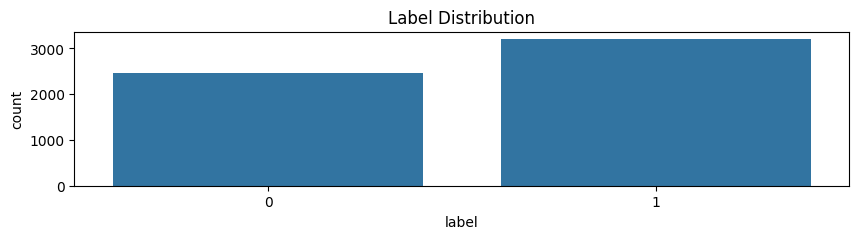

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
sns.countplot(data=df, x='label')
plt.title("Label Distribution")
plt.show()

# **Sentence Length**

In [ ]:
df['length'] = df['sentence'].str.len()

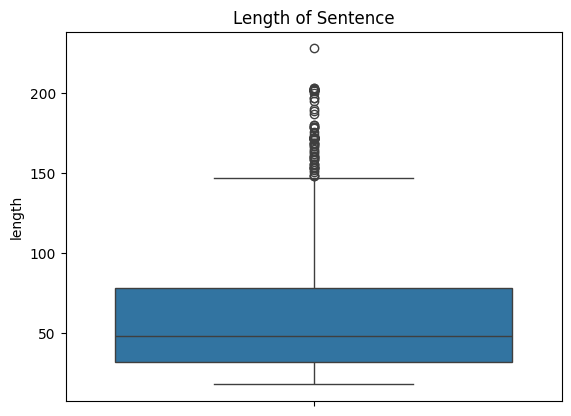

In [ ]:
sns.boxplot(data=df, y='length')
plt.title("Length of Sentence")
plt.show()

# **Word Count**

In [ ]:
def word_count(x):
    return len(x.split())

df['word_count'] = df['sentence'].apply(word_count)

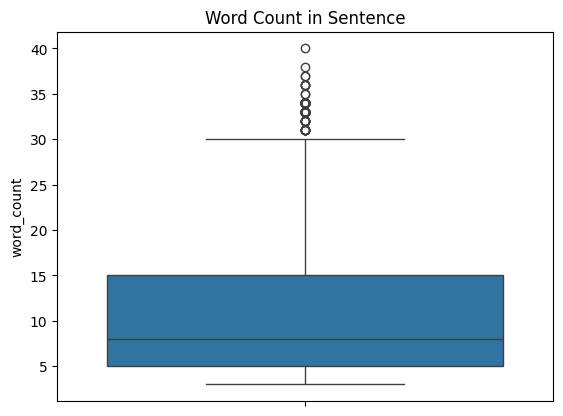

In [ ]:
sns.boxplot(data=df, y='word_count')
plt.title("Word Count in Sentence")
plt.show()

# **Word Cloud**

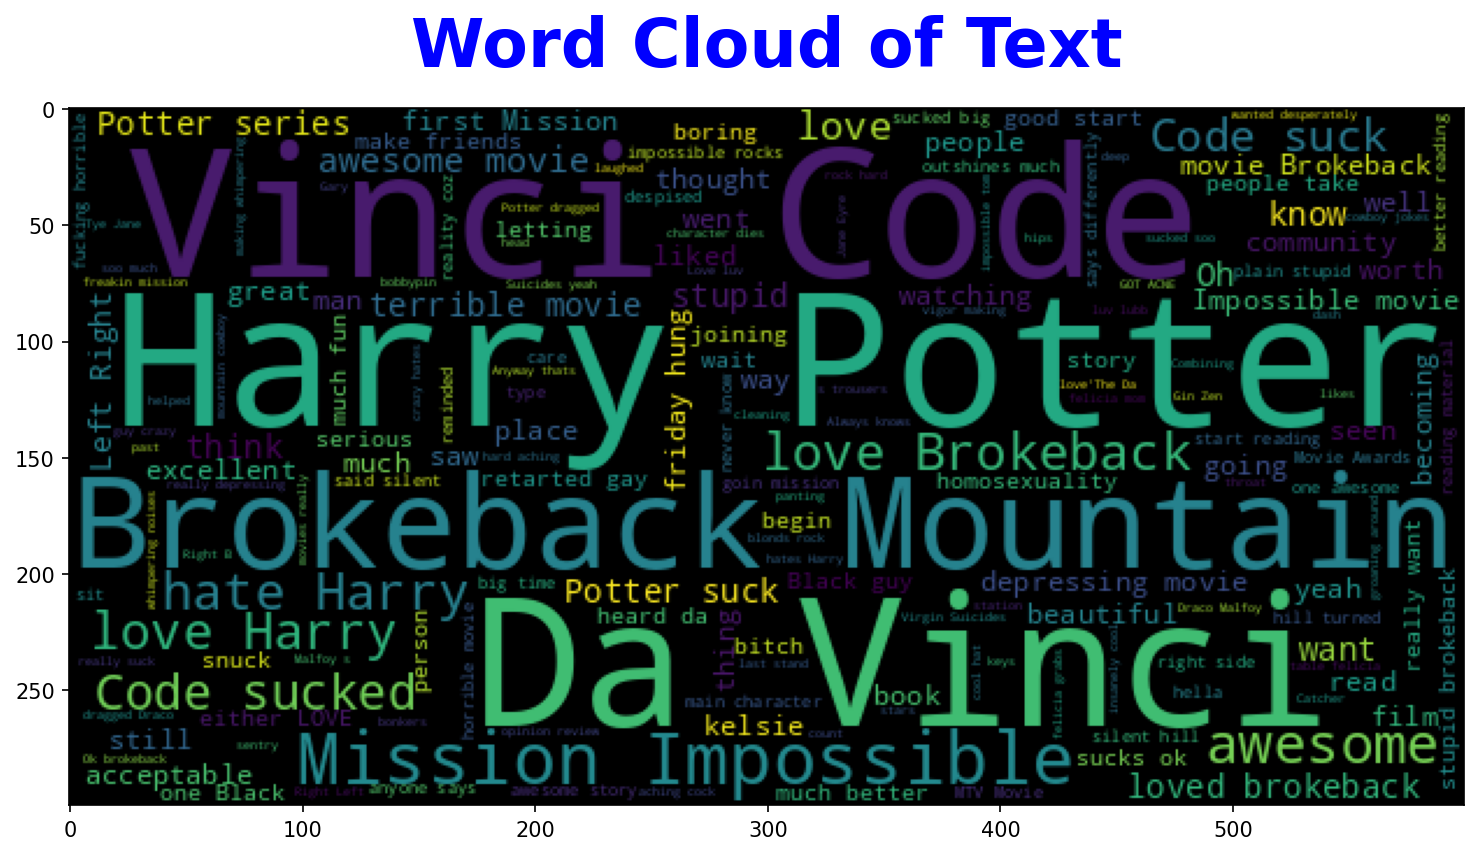

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize=(12,8),dpi=150)
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(df.sentence))
plt.title('Word Cloud of Text',color='blue',fontsize=32,fontweight='bold',pad=20)
plt.imshow(wc);

# **Data cleaning**

In [ ]:
def clean_text(data,col):
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=lower)
    return data

# **Display processed data**

In [ ]:
preprocessed_df = clean_text(df,'sentence')
preprocessed_df.head()

,sentence,label,length,word_count
0,ok brokeback mountain horrible movie,0,47,8
1,brokeback mountain awesome,1,34,5
2,friday hung kelsie went saw the da vinci code ...,0,77,15
3,going start reading harry potter series one aw...,1,92,17
4,is me harry potter suck,0,44,9


# **Checking Data Types of Sentences**

In [ ]:
print(preprocessed_df['sentence'].apply(type).value_counts())

sentence
<class 'str'>    5668
Name: count, dtype: int64


# **Dropping Missing Values in Sentences**

In [ ]:
preprocessed_df = preprocessed_df.dropna(subset=['sentence'])

# **Verify that labels are binary (0 or 1)**

In [ ]:
# Verify that labels are binary (0 or 1)
assert df['label'].isin([0, 1]).all(), "The labels should be binary (0 or 1)."

# **Tokenization Function Definition**

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding=True, truncation=True)

# **Train-Test Split**

In [ ]:



# Train-test split
train_df, test_df = train_test_split(preprocessed_df, test_size=0.3, random_state=42)




# **Load Tokenizer**

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# **Convert DataFrames to Hugging Face Dataset Format**


In [ ]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# **Tokenize Train and Test Datasets**

In [ ]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3967 [00:00<?, ? examples/s]

Map:   0%|          | 0/1701 [00:00<?, ? examples/s]

# **Set Dataset Format for PyTorch**

In [ ]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'], output_all_columns=False)
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'], output_all_columns=False)


# **Load Pre-trained BERT Model for Classification**

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Define Training Arguments**

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",   # Set evaluation strategy to 'epoch'
    save_strategy="epoch",         # Align save strategy with evaluation strategy
    report_to="none",              # Disable logging to W&B
    load_best_model_at_end=True,
    push_to_hub=False
)


# **Initialize Data Collator**

In [ ]:
# Data collator (dynamically pad within each batch)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# **Initialize Trainer**

In [ ]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)



# **Train the Model**

In [ ]:

# Train the model
trainer.train()



Epoch,Training Loss,Validation Loss
1,0.002800,0.046767
2,0.000600,0.019620
3,0.000200,0.042277


TrainOutput(global_step=744, training_loss=0.10482048878091968, metrics={'train_runtime': 262.3858, 'train_samples_per_second': 45.357, 'train_steps_per_second': 2.836, 'total_flos': 256114973509080.0, 'train_loss': 0.10482048878091968, 'epoch': 3.0})

# **Plot Training and Validation Loss**

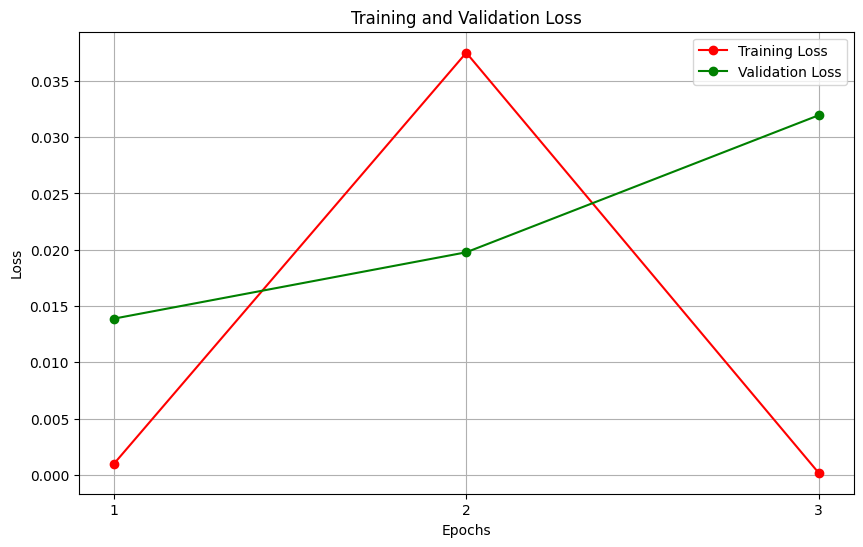

In [ ]:
import matplotlib.pyplot as plt


train_losses = [0.001000, 0.037500, 0.000200]  # Training Losses
valid_losses = [0.013885, 0.019778, 0.031941]  # Validation Losses

# Epochs (x-axis)
epochs = range(1, len(train_losses) + 1)


plt.figure(figsize=(10, 6))  #
plt.plot(epochs, train_losses, color='red', marker='o', label='Training Loss')
plt.plot(epochs, valid_losses, color='green', marker='o', label='Validation Loss')


plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid()
plt.legend()


plt.show()


# **Evaluate the Model**

In [ ]:


# Evaluate the model
predictions = trainer.predict(test_dataset)


# **Make Predictions and Calculate Accuracy**

In [ ]:
preds = np.argmax(predictions.predictions, axis=-1)
accuracy = accuracy_score(test_dataset['label'], preds)
print(f"Accuracy: {accuracy:.4f}")



Accuracy: 0.9959


# **Confusion Matrix**

Unique labels in y_true: tensor([0, 1])
[[728   3]
 [  4 966]]


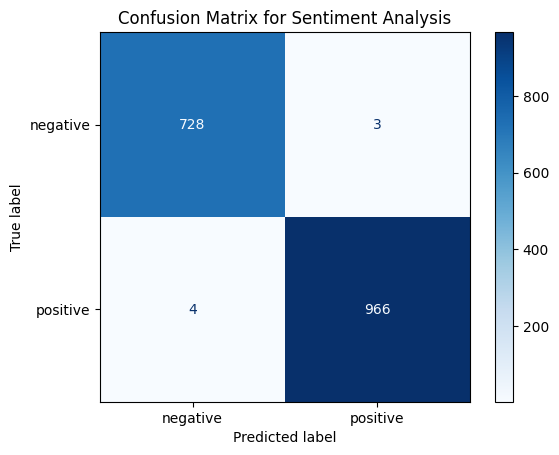

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
unique_labels = test_dataset['label'].unique()
print(f"Unique labels in y_true: {unique_labels}")
cm = confusion_matrix(test_dataset['label'], preds,  labels=unique_labels)
print (cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Sentiment Analysis')
plt.show()

# **CLASSIFICATION REPORT**

In [ ]:
# Classification report
report = classification_report(test_dataset['label'], preds, target_names=["negative", "positive"])
print(report)

              precision    recall  f1-score   support

    negative       0.99      1.00      1.00       731
    positive       1.00      1.00      1.00       970

    accuracy                           1.00      1701
   macro avg       1.00      1.00      1.00      1701
weighted avg       1.00      1.00      1.00      1701



In [ ]:
misclassified_indices = [i for i in range(len(test_dataset)) if test_dataset[i]['label'] != preds[i]]

# Display misclassified items
print("\nMisclassified items:")
for idx in misclassified_indices:
    sentence = test_dataset['sentence'][idx]
    true_label = test_dataset['label'][idx]
    predicted_label = preds[idx]
    print(f"Sentence: {sentence}\nTrue Label: {true_label}, Predicted Label: {predicted_label}\n")





Misclassified items:
Sentence: st nd harry potter movies clearly best funniest
True Label: 1, Predicted Label: 0

Sentence: sick books right now must say da vinci code awesome
True Label: 1, Predicted Label: 0

Sentence: personally neither hate love da vinci code
True Label: 1, Predicted Label: 0

Sentence: harry potter dumb
True Label: 0, Predicted Label: 1

Sentence: da vinci codesucked ballz
True Label: 0, Predicted Label: 1

Sentence: ah nothin love heather shes great hate will brokeback mountain stites
True Label: 0, Predicted Label: 1

Sentence: its hard decide move ti see good ones playing would love see da vinci code hand over the hedge looks funny
True Label: 1, Predicted Label: 0

